<h3> Data Project</h3>

In this project we want to (i) learn how to call the Yahoo Finance (yf) API to load in financial market data and (ii) use this to examine the implied volatility for a given asset. To do this, we load in option chains data and manipulate this to construct an implied volatility surface plot. The reader may know of the famous black-scholes formula, which actually suggests that implied volatility is constant. However in practice, this is far from the truth. As we shall implied volatility is a function of the options expiry/strike price and together all options thus form a term-like structure for market implied volatility. 

It must be noted that the yf API is free so data is not optimal and thoroughly calibrated however, our results seem consistent with what one might expect. 

<h3>Elementary option definitions</h3>

An option is a contractual agreement between two counterparts. The seller issues a contract imbedded with the "option" of buying an underlying security at a predetermined price on a given future date. The future price is called the "strike price". Thus, given the spot price $S_t$ at time $t$ and strike price $K$ the call option value at expiry time $T$ is thus 

$$C_T = \max(S_T-K,0)$$

and vice versa for the put. The argueably "hard" part is to determine the fair value at time $t$ or "today". This is not the scope of this project so we just take it for given that this can be described by

$$
C(S_t) = N(d_1)S_t - N(d_2)Ke^{-r(T-t)}
$$

with

$$d_1 = \frac{1}{\sigma \sqrt{T-t}}\bigg[ \ln \bigg( \frac{S_t}{K} \bigg) + \bigg(r + \frac{\sigma^2}{2} \bigg)(T-t)\bigg] \; \text{and} \; d_2 = d_1 - \sigma \sqrt{T-t}$$

where $N(\cdot)$ is a cumulative distribution function (CDF) $r$ the risk-free rate and $\sigma$ the assets volatility. As seen from the formula above the only unknown variable is the volatility $\sigma$. Thus an analytical implied volatility of the option can be obtained by solving 

$$
C_t(S_t, K, T, \sigma, r) = C^{obs}
$$

where $C^{obs}$ is the observed option value trading at the market. Yahoo finance has a measurement themselves for implied volatility for the listed options so we will not calculate these ourselves. However, the theory above suits the purpose of intuitively explaining the concept of deriving implied volatility measures from options prices.

In [44]:
# Importing Libraries
import numpy as np 
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
from datetime import date, timedelta

We start by defining a function that returns the options chains for a given ticker input. We append puts and calls to a "chains" dataframe respectively, together with the option charateristics e.g. expiration that we calculate by taking the difference between the expiry and todays date.

In [45]:
def option_chains(ticker): 
    asset = yf.Ticker(ticker) 
    expirations = asset.options
    chains = pd.DataFrame()
    for expiration in expirations:
        opt = asset.option_chain(expiration)
        calls = opt.calls 
        calls["optionType"] = "call"
        puts = opt.puts
        puts["optionType"] = "put"
        chain = pd.concat([calls, puts])
        chain["expiration"] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        chains = pd.concat([chains, chain])
    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    return chains

From here on we choose the VOO ETF as the ticker which we are going to be looking at. We tried with more liquid assets like AAPL, GOOG, SPY etc. however it seems YF does not keep option chains in these readily available in their API - the results are absurd, and would probably also be too high-frequency data to keep in a free API. Let us try to call the function to display perhaps the head (i.e. the top 5 rows) of our the returned dataframe.

In [90]:
option_chains("VOO").head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expiration,daysToExpiration
0,VOO230616C00175000,2022-09-08 14:36:45+00:00,175.0,193.30,160.3,165.0,0.0,0.0,NaN,1,0.000010,True,REGULAR,USD,call,2023-06-16 23:59:59,22
1,VOO230616C00180000,2022-08-12 18:21:23+00:00,180.0,212.00,192.7,197.5,0.0,0.0,28.0,28,0.000010,True,REGULAR,USD,call,2023-06-16 23:59:59,22
2,VOO230616C00215000,2023-01-27 19:25:13+00:00,215.0,161.87,149.7,153.4,0.0,0.0,2.0,1,0.000010,True,REGULAR,USD,call,2023-06-16 23:59:59,22
3,VOO230616C00220000,2023-03-22 18:40:20+00:00,220.0,150.40,158.0,161.3,0.0,0.0,NaN,3,1.027349,True,REGULAR,USD,call,2023-06-16 23:59:59,22
4,VOO230616C00240000,2023-05-23 19:52:39+00:00,240.0,141.78,0.0,0.0,0.0,0.0,21.0,26,0.000010,True,REGULAR,USD,call,2023-06-16 23:59:59,22


and we see that the function works as intended and generates a dataframe for us with all the needed metrics + a few unnecessary which we will disregard. The dataframe above only shows us the first 5 strikes of call options but the whole dataframe contains tons of expiries and strikes for both put and call options, but it is simply too large to display in a useful matter. As mentioned we get the "impliedVolatility" column which we will now use to generate our implied volatility surface plot. 

In [70]:
# Define a variable with our dataframe and defining put and call options
options = option_chains("VOO")
calls = options[options["optionType"]=="call"]
puts = options[options["optionType"]=="put"]

# e.g. the calls where df['optionType'] == 'call'
calls.head(3)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expiration,daysToExpiration
0,VOO230616C00175000,2022-09-08 14:36:45+00:00,175.0,193.30,160.3,165.0,0.0,0.0,NaN,1,0.00001,True,REGULAR,USD,call,2023-06-16 23:59:59,22
1,VOO230616C00180000,2022-08-12 18:21:23+00:00,180.0,212.00,192.7,197.5,0.0,0.0,28.0,28,0.00001,True,REGULAR,USD,call,2023-06-16 23:59:59,22
2,VOO230616C00215000,2023-01-27 19:25:13+00:00,215.0,161.87,149.7,153.4,0.0,0.0,2.0,1,0.00001,True,REGULAR,USD,call,2023-06-16 23:59:59,22


We now want to make our implied volatility surface plot showing the "term structure" of volatility for the given asset. This should give some indication of the risks involved with the specific asset under examination. 

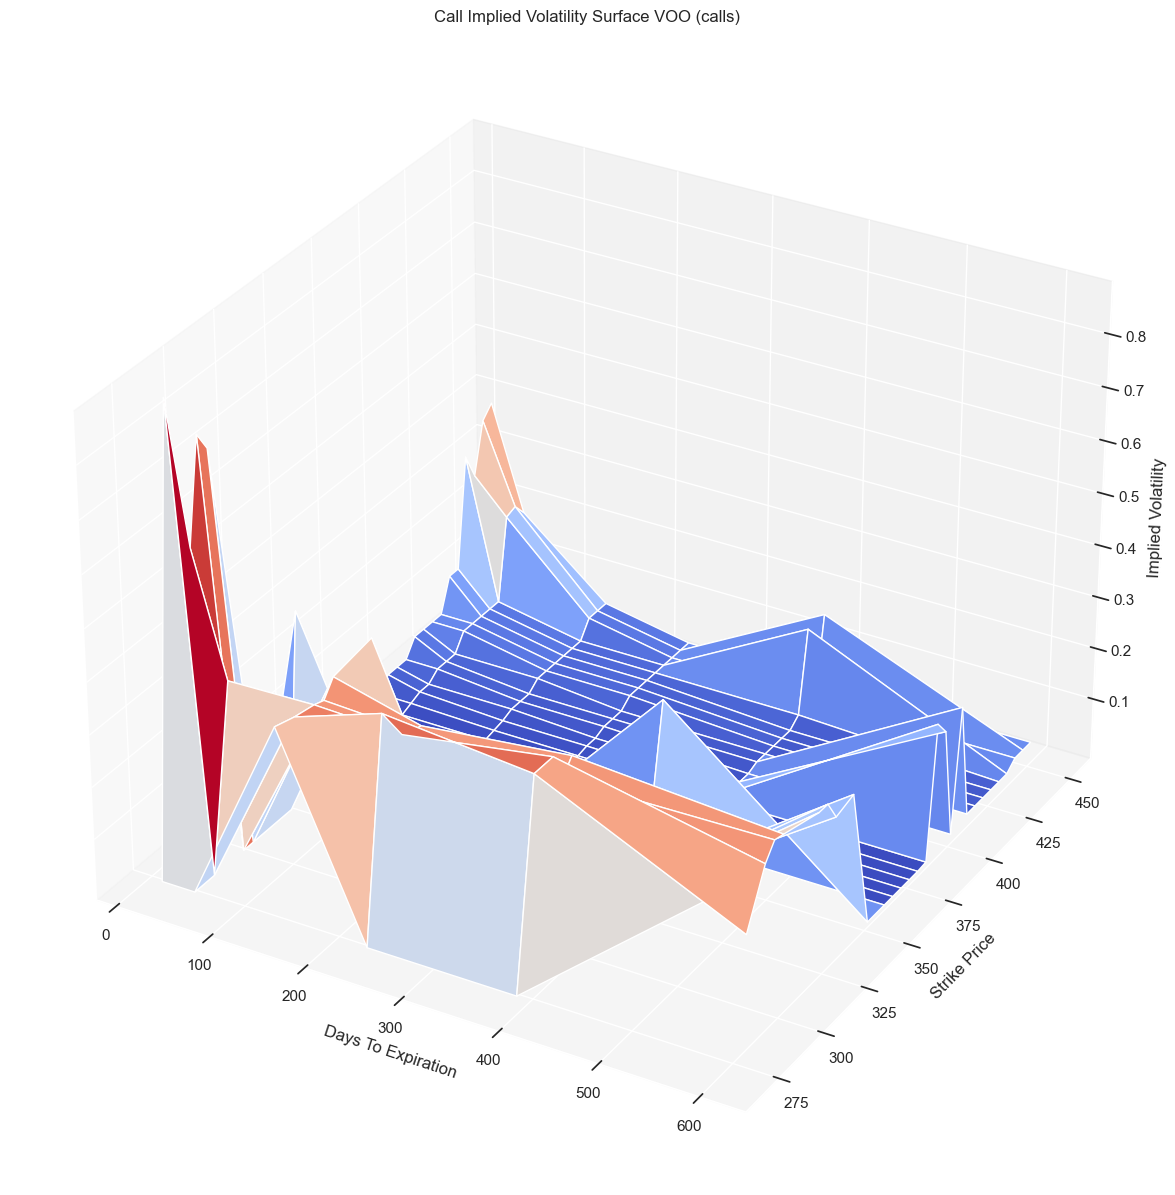

In [94]:
# Define a variable with our dataframe and defining put and call options
options = option_chains("VOO")
calls = options[options["optionType"]=="call"]
puts = options[options["optionType"]=="put"]

# show expirations
set(calls.expiration)
set(puts.expiration)

# Setting the approximate spot price to determine which calls are at the money
calls_at_strike = options[options["strike"] == 380]

# Creating surface
surface = (
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

# Instantiating figure object 
fig = plt.figure(figsize=(15, 15))

# Adds subplot with projection
ax = fig.add_subplot(111, projection='3d')

# Get values from dataframe
x, y, z = surface.columns.values, surface.index.values, surface.values
X, Y = np.meshgrid(x, y)

# Setting labels, visuals and showing plot
ax.set_xlabel("Days To Expiration")
ax.set_ylabel("Strike Price")
ax.set_zlabel("Implied Volatility")
ax.set_title("Call Implied Volatility Surface VOO (calls)")
ax.patch.set_facecolor('white')
ax.plot_surface(X, Y, z, cmap="coolwarm")
plt.show()

<h3>Conclusion</h3>

As expected the data seems a bit distorted and the graph shows that not all data points are available and as a result the plot seems a bit distorted and far from "continous". However when we look at it, in general the implied volatility values are consistent with what expect from theory. For example we see that around the current spot price 380, the price is very less influence by the implied volatility. One thing that does however not hold true is that implied volatility becomes constant when days to expiration becomes sufficiently large. This is clearly not the case in the figure above, but might be because there are some strike prices for which there not exist option quotes with 600 days to expiration. We have run the code a few times and in market open if of course changes every time due to live updates from the API - which is then again also the smart thing about it. 

<h3>Extra - the VIX index</h3>

Another measure of implied volatility is the VIX-index. The VIX-index calculates the risk-neutral expectations to future 30-day realized variance by replicating a continuum of options prices (see CBOE white paper). The VIX-index looks at S&P500 options, and is thus widely recognized as the overall market's volatility expectations or sometimes popularly called "the fear index". Let's try to plot the VIX-index against the actual underlying S&P500 index to see what their relation is.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'The Price of SP 500 vs The VIX')

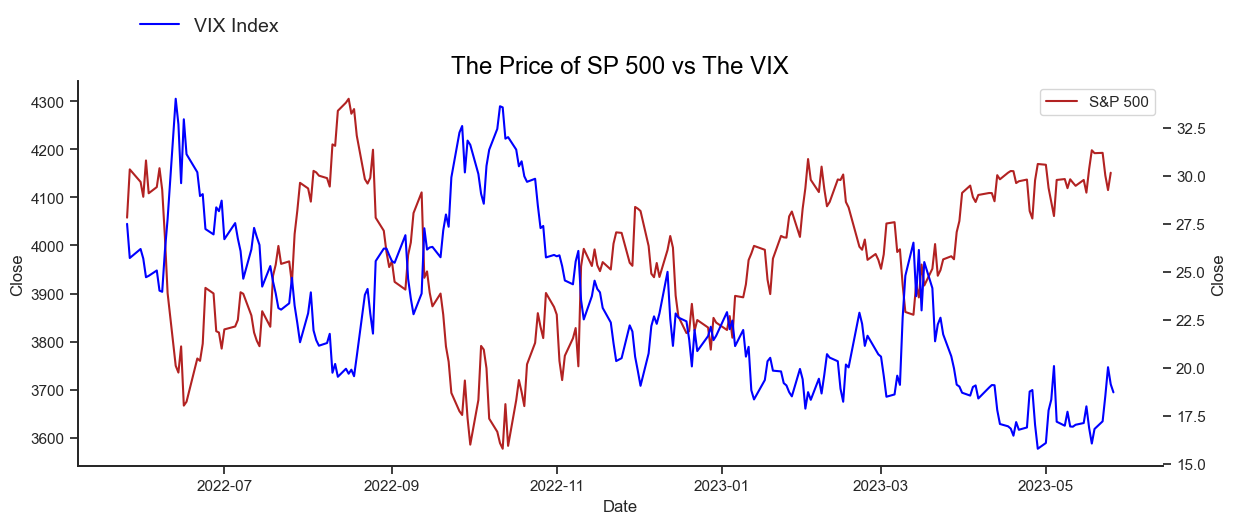

In [98]:
# Defining time period
Start = date.today() - timedelta(365)
Start.strftime('%Y-%m-%d')

End = date.today() + timedelta(2)
End.strftime('%Y-%m-%d') 

# Defining function that downloads the closing price of a specific ticker
def closing_price(ticker):
    Asset = pd.DataFrame(yf.download(ticker, start=Start,
      end=End))     
    return Asset

SP = closing_price('^GSPC') # Setting variable for S&P 500
SP.reset_index(inplace=True) 

VIX = closing_price('^VIX') # Setting variable for VIX
VIX.reset_index(inplace=True)

# Creating plot
plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=SP,x="Date",y='Close',color='firebrick', label='S&P 500')
ax2 = plt.twinx()
sns.lineplot(data=VIX,x="Date",y='Close',color='blue', label='VIX Index', ax=ax2)
sns.despine()
plt.legend(loc=(0.05,1.1),ncol=2,frameon=False, prop={'size': 14})
plt.title("The Price of SP 500 vs The VIX",size='x-large',color='black')

As we can see VIX and S&P500 are negatively correlated which primarly stems from the fact that financial market returns have a "leverage effect" so that negative returns happens quicker than positive. Thus, it looks like a wise idea to follow the VIX-index levels as an investor or trader. 